In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy as sp
from scipy.signal import savgol_filter as savgol 
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib import cm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF','#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
npg_color_list = []
for this_color in npg_colors: 
    npg_color_list.append(list(int(this_color[1:][i:i+2], 16)/255 for i in (0, 2, 4)))
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
plt.rcParams.update({'font.size':18});
plt.rc('lines',linewidth=3);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
ncolors = 10
plt.rc('axes', axisbelow=True)

from preprocess import *
from dmd import *
from sensor_placement import *
from query_uniprot import *
from regions import *
from plot_ellipsoid import *

#### Import data and metadata

In [2]:
# normalized gene expression in TPM generated with Kallisto
datadir = 'data/tpm_removed_low_count_genes.csv' 
df = pd.read_csv(datadir)

ntimepts = 12 # total number of timepoints in df
reps = [0,2] # downselect to the replicates used in our work (2nd replicate not used due to experimental issue)
nreps = 3 # total number of replicates in df
# tp_list = list(range(2,ntimepts-1)) # the timepoints to be considered for modeling 
# malathion was introduced before after the 2nd timepoint not using the last timepoint due to experimental issue

# getting sample labels and transcript IDs from the df
sampleLabels = list(df.columns[1:])
txIDs = list(df.iloc[:,0])
# getting transcriptome dynamics
df = df.iloc[:,1:] 

#### Preprocess to get several different subsets of the data, metadata (gene names, reps, etc.)

In [3]:
data_c_orig, data_t_orig, data_c, data_t, keepers, data_c_keep, data_t_keep, \
                                txIDs_keep, data_fc, data_fc_norm = \
                                process_df(df,sampleLabels,nreps,reps,ntimepts,txIDs)

print('num genes x num timepoints x num replicates')
print(data_fc_norm.shape) # genes x timepoints x replicates

genbank_path = 'data/GCA_000009225.1_ASM922v1_genomic.gbff'
cdsFasta_path = 'data/GCA_000009225.1_ASM922v1_cds_from_genomic.fa'
genes_keep, locus_tags_keep, locations = getRecords(cdsFasta_path,genbank_path,txIDs_keep)


num genes x num timepoints x num replicates
(624, 9, 2)


#### Perform dynamic mode decomposition on transcriptome dynamics

In [4]:
r = 10 # number of dynamic modes
A,Atilde,data_fc_norm_red,U_r,cd,eVals_r,eVecs_r,Phi,b_r0,b_r1 = \
        dmd(data_fc_norm,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3) #trimThesh=2.5e-3

Coefficient of determination for n-step prediction is 9.393e-01
Coefficient of determination for n-step prediction is 9.190e-01


#### Observability maximization with closed form solution

Some unanswered questions:
- Which genes would be the ones that best reconstruct x0, in each condition separately? 
- Maybe we can have a plot of both of those genes as a new Fig. 3 and have Fig. 4 be the one with the fold-change


In [5]:
# First, we will compute the Gram matrix which encodes all known information 
nT = 8

# this G is computed using non-projected data (can be slow for high-dimensional data)
G = gram_matrix(A,data_fc_norm[:,0,:],nT=nT,reduced=False)
# Gt is computed using projected data and KO and Gt_recon is simply projected back up to original dimension
Gt, Gt_recon = gram_matrix(Atilde,data_fc_norm_red[:,0,:],nT=100,reduced=True,projection_matrix=U_r)


In [6]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if p=1)
D, V = sp.linalg.eig(G,left=False,right=True)
Dt,Vt = sp.linalg.eig(Gt,left=False,right=True)
Dt_recon, Vt_recon = sp.linalg.eig(Gt_recon,left=False,right=True)

In [7]:
p = 1
# W = Vt_recon[:,0:p].T
W = V[:,0:p].T
sorted_inds = list(np.argsort(np.abs(W[0,:]))) # based on top eigenvector only
sorted_tags = [locus_tags_keep[x] for x in sorted_inds]
Wsorted = deepcopy(W)[:,sorted_inds]

p = 5
Wp = (V[:,0:p].T)[:,sorted_inds]

#### Observability maximization with SQP (force weights to be > 0 and enforce sparsity) 
- Takes between 1 and 10 minutes per run for $O(10^3)$ genes (depends on initialization)

In [8]:
# doRun = False
# doSave = False
# if doRun: 
#     Clist = []
#     for ii in range(10): # run the observability analysis 10 times
#         C,seed = energy_maximization_with_uni_dist(data_fc_norm,A,data_fc_norm.shape[1],data_fc_norm.shape[1]-1,IC=0) 
#         C = (C/C.max()).T # normalizing C to be b/w 0 and 1
#         C = list(np.squeeze(C))
#         Clist.append(C)

# if doSave: 
# # dump observability result 
#     pickle.dump(Clist,open('data/Clist.pkl','wb'))
        
        
# if not doRun: # grab from previously saved pickle 
#     # retrieve Clist from pickle file
#     Clist = pickle.load(open('data/Clist.pkl','rb'))
    
# # sort from lowest to highest sampling weight and get mean/std over the runs
# C = list(np.mean(Clist,axis=0))
# Csorted = np.sort(C)
# CsortedInds = list(np.argsort(C)) # from lowest to highest rank

# # to get the error across runs, need each list in Clist to be sorted as in CsortedInds
# Ctmp = []
# for ii in range(len(Clist)):
#     Ctmp.append(list(np.array(Clist[ii])[CsortedInds]))
    
# Csorted_err = np.std(np.array(Ctmp),axis=0)

Measure reconstruction accuracy for varying timepoints and number of genes selected

In [9]:
# takes several minutes to run

samplingFreq = 30

doRun = False
if doRun:
    rho_T10 = reconstruct_x0(data_fc_norm,10,A,W,sorted_inds,samplingFreq=samplingFreq,order='top') # second argument is number of timepoints
    rho_T9 = reconstruct_x0(data_fc_norm,9,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T8 = reconstruct_x0(data_fc_norm,8,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T7 = reconstruct_x0(data_fc_norm,7,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T6 = reconstruct_x0(data_fc_norm,6,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T5 = reconstruct_x0(data_fc_norm,5,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T4 = reconstruct_x0(data_fc_norm,4,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T3 = reconstruct_x0(data_fc_norm,3,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T2 = reconstruct_x0(data_fc_norm,2,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')
    rho_T1 = reconstruct_x0(data_fc_norm,1,A,W,sorted_inds,samplingFreq=samplingFreq,order='top')

doRunRand = False
if doRunRand: 
    rho_T10_rand = reconstruct_x0(data_fc_norm,10,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T9_rand = reconstruct_x0(data_fc_norm,9,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T8_rand = reconstruct_x0(data_fc_norm,8,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T7_rand = reconstruct_x0(data_fc_norm,7,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T6_rand = reconstruct_x0(data_fc_norm,6,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T5_rand = reconstruct_x0(data_fc_norm,5,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T4_rand = reconstruct_x0(data_fc_norm,4,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T3_rand = reconstruct_x0(data_fc_norm,3,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T2_rand = reconstruct_x0(data_fc_norm,2,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
#     rho_T1_rand = reconstruct_x0(data_fc_norm,1,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')

doSave = False
if doSave: 
    -1
#     pickle.dump([rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1],open('data/reconstructions.pkl','wb'))
#     pickle.dump([rho_T10_rand,rho_T9_rand,rho_T8_rand,rho_T7_rand,rho_T6_rand,rho_T5_rand,rho_T4_rand,rho_T3_rand,rho_T2_rand,rho_T1_rand],open('data/reconstructions_random.pkl','wb'))

if not doRun:
    rho_list = pickle.load(open('data/reconstructions.pkl','rb'))
if not doRunRand:
    rho_rand_list = pickle.load(open('data/reconstructions_random.pkl','rb'))

#### Results dataframe with selected encoder genes and metadata

In [147]:
# their locus_tags
tags = ['6124','0841','1823','5502','1836','4736','3761','4150','0376','1815','0953','1358','1302A','4612','1380']
tags = ['PFLU_'+tag for tag in tags]
search_names = 'genes,protein names,comment(FUNCTION),go,go(biological process),go(molecular function)'

df_up_new = process_query(tags,search_names,locus_tags_keep,W[0],Wsorted[0])
# adjust long gene names for manuscript
df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_3761')] = 'Uncharacterized \n protein I'
df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_1358')] = 'Uncharacterized \n protein II'
df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_4612')] = 'Putative outer membrane porin \n A protein'
df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_0376')] = 'Putative ABC transport \n system'
df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_4736')] = 'anti-sigma \n 28 factor'

doSave = False
if doSave: 
    df_up_new.to_csv('data/encoder_genes_metadata.csv',sep=',',index=False)
df_up_new

<ipython-input-147-b45bd31ecff5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_3761')] = 'Uncharacterized \n protein I'
<ipython-input-147-b45bd31ecff5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_1358')] = 'Uncharacterized \n protein II'
<ipython-input-147-b45bd31ecff5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_

,gene,protein,function,go,go_bp,go_mf,locus_tag,obs_rank,tag_ind
0,atpB,ATP synthase subunit a (ATP synthase F0 sector...,FUNCTION: Key component of the proton channel;...,integral component of membrane [GO:0016021]; p...,,"proton-transporting ATP synthase activity, rot...",PFLU_6124,0.48,140
1,petA,Ubiquinol-cytochrome c reductase iron-sulfur s...,FUNCTION: Component of the ubiquinol-cytochrom...,cytoplasm [GO:0005737]; integral component of ...,,"2 iron, 2 sulfur cluster binding [GO:0051537];...",PFLU_0841,2.24,213
2,sucC,Succinate--CoA ligase [ADP-forming] subunit be...,FUNCTION: Succinyl-CoA synthetase functions in...,ATP binding [GO:0005524]; magnesium ion bindin...,tricarboxylic acid cycle [GO:0006099],ATP binding [GO:0005524]; magnesium ion bindin...,PFLU_1823,4.97,461
3,rpoA,DNA-directed RNA polymerase subunit alpha (RNA...,FUNCTION: DNA-dependent RNA polymerase catalyz...,DNA binding [GO:0003677]; DNA-directed 5'-3' R...,"transcription, DNA-templated [GO:0006351]",DNA binding [GO:0003677]; DNA-directed 5'-3' R...,PFLU_5502,6.41,567
4,fabA,3-hydroxydecanoyl-[acyl-carrier-protein] dehyd...,FUNCTION: Necessary for the introduction of ci...,cytoplasm [GO:0005737]; (3R)-hydroxymyristoyl-...,fatty acid biosynthetic process [GO:0006633],(3R)-hydroxymyristoyl-[acyl-carrier-protein] d...,PFLU_1836,9.62,470
5,anti-sigma \n 28 factor,Anti-sigma-28 factor (Negative regulator of fl...,FUNCTION: Responsible for the coupling of flag...,bacterial-type flagellum organization [GO:0044...,bacterial-type flagellum organization [GO:0044...,,PFLU_4736,11.70,385
6,Uncharacterized \n protein I,Uncharacterized protein,,,,,PFLU_3761,13.78,169
7,cspA2,Major cold shock protein,,cytosol [GO:0005829]; nucleic acid binding [GO...,,nucleic acid binding [GO:0003676],PFLU_4150,18.59,257
8,Putative ABC transport \n system,"Putative ABC transport system, exported protein",,membrane [GO:0016020]; outer membrane-bounded ...,amino acid transport [GO:0006865],ligand-gated ion channel activity [GO:0015276],PFLU_0376,19.23,104
9,gltA,Citrate synthase,,cytoplasm [GO:0005737]; citrate (Si)-synthase ...,tricarboxylic acid cycle [GO:0006099],citrate (Si)-synthase activity [GO:0004108],PFLU_1815,23.08,453


#### Get promoter sequences corresponding to selected encoder genes

In [12]:
intergenic_records = get_interregions(genbank_path,intergene_length=100)
# get promoter sequences (intergenic regions) for all the genes modeled
promoter_records = get_promoterregions_v2(locations,locus_tags_keep,intergenic_records,genbank_path,rel_dist_thresh=5000)

### Figures
- Figure 2 and 3 are generated here, for Figures 4 and 5 see reporters.ipynb and virtual_sensors.ipynb, respectively

In [13]:
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/'
corr_tspan = list(range(10,100,10)) # for xaxis in many figures

#### Subfigures for FIgure 2 in manuscript

In [ ]:
# plot the eigenvalues on the unit circle

savefig = False
# automate mode pairing (data is real-valued, complex eigs comes with a conjugate pair -- no need to plot both)
mode_pairs = []
cnt = 0
while cnt in range(len(eVals_r)): 
    if cnt+1 != len(eVals_r): # have we reached the boundary?
        if np.abs(eVals_r[cnt]) == np.abs(eVals_r[cnt+1]): # if no, then check if the two are c.c. pairs
            mode_pairs.append([cnt,cnt+1])
            cnt += 2
        else: # if no, and not c.c. pairs
            mode_pairs.append([cnt])
            cnt += 1
    else: # if boundary
        mode_pairs.append([cnt])
        cnt += 1
print('mode pairs: ', mode_pairs)

# size the eigenvalue marker by corresponding mode power ||Phi_i||
mode_powers = np.linalg.norm(Phi,axis=0)
my_ms = [9*2**n for n in mode_powers] # the 9*2**n is an arbitrary scaling for marker size

fig1,ax1 = plt.subplots(1,1,figsize=(7,7))
fig2,ax2 = plt.subplots(1,1,figsize=(7,7))
theta = np.linspace(0,2*np.pi,200)
ax1.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)

markers = ['o','s','d','^','v','>']
for ii in range(len(mode_pairs)):
    scaled_mode = np.real(eVals_r[ii]*b_r1[mode_pairs[ii][0]])

    ax2.plot(corr_tspan,savgol(scaled_mode,3,1),'-',c=npg_colors[ii],lw=4,label='Mode ' + str(mode_pairs[ii]))
    ax1.plot(np.real(eVals_r[mode_pairs[ii][0]]),np.imag(eVals_r[mode_pairs[ii][0]]),
                marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)
    if len(mode_pairs[ii]) == 2: 
        ax1.plot(np.real(eVals_r[mode_pairs[ii][1]]),np.imag(eVals_r[mode_pairs[ii][1]]),
                marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)

ax1.axis('equal')
ax1.set_xlabel(r'$\mathregular{Re(\lambda)}$',fontsize=22)
ax1.set_ylabel(r'$\mathregular{Im(\lambda)}$',fontsize=22)
ax1.set_ylim(-1,1)
ax1.set_yticks(np.arange(-1,1.5,0.5))
ax1.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax1.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')

ax2.set_xlabel('Time (minutes)',fontsize=22)
ax2.set_ylabel('Dynamic mode amplitude',fontsize=22)
ax2.legend(frameon=False,ncol=1)
ax2.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax2.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')

for side in ax1.spines.keys():
    ax1.spines[side].set_linewidth(2)
    ax2.spines[side].set_linewidth(2)

ax1.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
ax2.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
    
if savefig: 
    fig1.savefig(figDir + 'fig2/eigvals.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig2.savefig(figDir + 'fig2/amplitudes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [ ]:
# make a plot that shows magnitude of eigvals for varying r
# didn't make it into manuscript

savefig = False

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

r_list = [8,10,12,14,16]
evals_list = []
for rr in r_list: 
    _,_,_,_,_,evals,_,_,_,_ = \
                            dmd(data_fc_norm,rank_reduce=True,r=rr,trim=True,trimThresh=2e-3)
    evals_list.append(evals)

fig,ax = plt.subplots(1,1,figsize=(7,7))
my_ms = ['>','o','<','v','^']
for ii,evals in enumerate(evals_list):
    ax.plot(np.sort(np.abs(evals))[::-1],my_ms[ii],mec='k',c=npg_colors[ii],mew=1,ms=12
            ,label='r = '+str(r_list[ii]))
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.set_ylabel(r'$|\mathregular{\lambda}|$',fontsize=26)
ax.set_xticks(range(0,20,5))
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
fig.legend(frameon=False,bbox_to_anchor=(1,0.9))
if savefig: 
    plt.savefig(figDir + 'fig2/magEvals_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [ ]:
##### cluster genes based on modes

savefig = False

Phi_mag = np.abs(Phi)

kmax = 20 # get most impacted genes
kmax_inds = []
for ii in range(Phi_mag.shape[1]):
    kmax_inds.append(Phi_mag[:,ii].argsort()[-kmax:])

heights = [0.85,1.5]
my_figsize = (5.5,7)

fig1,axs1 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[0]*b_r0[0])
axs1[0].plot(corr_tspan,savgol(scaled_mode,3,1),'o-',ms=10.5,mec='k',mew=2,c='k',mfc=npg_color_list[0]+[0.7],lw=1.5)
for ii in range(6,16): # only plot the top 10 
    axs1[1].plot(corr_tspan,savgol(data_fc[kmax_inds[0][ii],:,1],3,1),'o-',c='k',mfc=npg_color_list[0]+[0.7],
           ms=10.5,mec='k',mew=2,lw=1.5)
for jj,ax in enumerate(axs1.reshape(-1)):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))   
plt.tight_layout()    
axs1[0].set_ylim(-24,20)
axs1[1].set_ylim(0.5,1.55)
axs1[0].set_ylabel('Mode 1 \n amplitudes',fontsize=18) 
axs1[1].set_ylabel('Fold change of \n first mode genes',fontsize=18) 

fig2,axs2 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[1]*b_r1[1])
axs2[0].plot(corr_tspan,savgol(scaled_mode,3,1),'o-',ms=10.5,mec='k',mew=2,c='k',mfc=npg_color_list[1]+[0.7],lw=1.5)
for ii in range(0,20): # only plot the top 10 
    axs2[1].plot(corr_tspan,savgol(data_fc[kmax_inds[1][ii],:,1],3,1),'o-',c='k',mfc=npg_color_list[1]+[0.7],
           ms=10.5,mec='k',mew=2,lw=1.5)
for jj,ax in enumerate(axs2.reshape(-1)):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))   
plt.tight_layout()    
axs2[0].set_ylim(-24,20)
axs2[1].set_ylim(0.5,1.55)
axs2[0].set_ylabel('Mode 2 \n amplitudes',fontsize=18) 
axs2[1].set_ylabel('Fold change of \n second mode genes',fontsize=18) 
    
fig3,axs3 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[5]*b_r1[5])
axs3[0].plot(corr_tspan,savgol(scaled_mode,3,1),'^-',ms=10.5,mec='k',mew=2,c='k',mfc=npg_color_list[3]+[0.7],lw=1.5)
for ii in range(10,kmax): # only plot the top 10 
    axs3[1].plot(corr_tspan,savgol(data_fc[kmax_inds[3][ii],:,1],3,1),'^-',c='k',mfc=npg_color_list[3]+[0.7],
           ms=10.5,mec='k',mew=2,lw=1.5)
for jj,ax in enumerate(axs3.reshape(-1)):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))   
plt.tight_layout()    
axs3[0].set_ylim(-24,20)
axs3[1].set_ylim(0.5,1.55)
axs3[0].set_ylabel('Mode 6 \n amplitudes',fontsize=18) 
axs3[1].set_ylabel('Fold change of \n sixth mode genes',fontsize=18) 

if savefig: 
    fig1.savefig(figDir + 'fig2/mode1_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig2.savefig(figDir + 'fig2/mode2_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig3.savefig(figDir + 'fig2/mode6_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [ ]:
##### visualize the preditions for several randomly selected genes
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

X_pred, cd_ = n_step_prediction(A,data_fc_norm,data_fc_norm.shape[1],data_fc_norm.shape[2])
Xpred = X_pred.reshape(len(A),data_fc_norm.shape[1],data_fc_norm.shape[2],order='F')

fig,axs = plt.subplots(3,2,figsize=(7,7),sharex=True,sharey=True)
fig.delaxes(axs[-1,-1])
pinds = [3,100,583,164,309] # plot these genes (selected randomly)
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(pinds):
        pind = pinds[ii]
        act_mean = np.mean(data_fc_norm[pind],axis=1)
        pred_mean = np.mean(Xpred[pind],axis=1)
        act_std = np.std(data_fc_norm[pind],axis=1)
        pred_std = np.std(Xpred[pind],axis=1)
        ax.plot(corr_tspan,act_mean,'o-',ms=8,lw=2,c='tab:blue')
        ax.plot(corr_tspan,pred_mean,'--',lw=4,c='tab:orange')
        ax.fill_between(corr_tspan,act_mean-act_std,act_mean+act_std,color='tab:blue',alpha=0.2)
        ax.fill_between(corr_tspan,pred_mean-pred_std,pred_mean+pred_std,color='tab:orange',alpha=0.2)
        # also plot a marker indicating that the IC is given as input to the model
        ax.plot(10,act_mean[0],'s',ms=18,c='m',mfc='None',mew=2.5)
        ax.set_xticks(range(20,100,20))
        for side in ax.spines.keys(): 
            ax.spines[side].set_linewidth(2.5)   
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
        ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))   
        if genes_keep[pind] != 'N/A':
            ax.set_title(genes_keep[pind],fontsize=18)
        else: 
            ax.set_title(locus_tags_keep[pind],fontsize=18)

fig.legend(['truth','8-step DMD \n prediction'],frameon=False,loc=(0.61,0.1),fontsize=20);
fig.text(0.5, -0.02, 'Time after malathion induction (minutes)', ha='center',fontsize=22);
fig.text(-0.01, 0.5, 'Standardized Fold Change', va='center', rotation='vertical',fontsize=22);
fig.text(0.72,0.256,r'$R^2=0.92$' '\n (all genes)',ha='center',fontsize=20)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir + 'fig2/error_timeseries.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [ ]:
# Visualize heatmaps for reconstructed data and DMD schematic
# plot for spectral expansion visualization
savefig = False

my_cmap = cmap = 'viridis' #sns.diverging_palette(230, 20, as_cmap=True) # 'YlGnBu'
phase_cmap = 'twilight'

eVals_r_phase = 2*np.abs(np.arctan(np.imag(eVals_r)/np.real(eVals_r)))
Phi_phase = 2*np.abs(np.arctan(np.imag(Phi)/np.real(Phi)))
b_phase = 2*np.abs(np.arctan(np.imag(b_r1[:,0:1])/np.real(b_r1[:,0:1])))

eVals_r_mag = np.abs(eVals_r)
Phi_mag = np.abs(Phi)
b_mag = np.abs(b_r1[:,0:1])

########## data ####################################################################
plt.figure(figsize=(0.4,8))
res = sns.heatmap(data_fc_norm[:,1:2,1],cmap=my_cmap,cbar=False)
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_xk.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

########## eigenvalues ####################################################################
plt.figure(figsize=(4,4))
res = sns.heatmap(np.diag(eVals_r_mag),cmap=my_cmap,cbar=False)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_evals_mag.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.figure(figsize=(4,4))
res = sns.heatmap(np.diag(eVals_r_phase),vmin=0,vmax=2*np.pi,cmap=phase_cmap,cbar=False)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_evals_phase.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show();

########## modes ####################################################################
plt.figure(figsize=(3,8))
res = sns.heatmap(Phi_mag,cmap=my_cmap,cbar=False)
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_modes_mag.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show();

plt.figure(figsize=(3,8))
res = sns.heatmap(Phi_phase,vmin=0,vmax=2*np.pi,cmap=phase_cmap,cbar=False)
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_modes_phase.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show();


########## amplitude ####################################################################
plt.figure(figsize=(0.4,4))
res = sns.heatmap(b_mag,cmap=my_cmap,cbar=False)
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_amplitude_mag.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.figure(figsize=(0.4,4))
res = sns.heatmap(b_phase,cmap=phase_cmap,cbar=False)
plt.xticks([])
plt.yticks([])
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
if savefig: 
    plt.savefig(figDir + 'fig2/heatmap_amplitude_phase.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [ ]:
# get color bar for the heatmaps above
savefig = False

fig, ax = plt.subplots(figsize=(5, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.cm.viridis # sns.diverging_palette(230, 20, as_cmap=True) # matplotlib.cm.YlGnBu
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(np.abs(eVals_r)))

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
# cb1.set_label('Magnitude')

# polar projection
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(40, 70, 1)
values = azimuths * np.ones((30, 361))
fig2, ax2 = plt.subplots(subplot_kw=dict(projection='polar'))
ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight')
ax2.set_yticks([])

    
if savefig: 
    fig.savefig(figDir + 'fig2/colorbar.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig2.savefig(figDir + 'fig2/polarbar.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show();

#### Subfigures for Figure 3 in manuscript

In [45]:
Xo1, Xo1_proj = finite_horizon_obs_gramian(A,V[:,0:1].T,10)
print('Xo1 volume:', np.linalg.det(Xo1_proj))
Xo2, Xo2_proj = finite_horizon_obs_gramian(A,V[:,1:2].T,10)
print('Xo2 volume:', np.linalg.det(Xo2_proj))
Xo3, Xo3_proj = finite_horizon_obs_gramian(A,V[:,2:3].T,10)
print('Xo3 volume:', np.linalg.det(Xo3_proj))

Xo1 volume: 2354.2642011233006
Xo2 volume: 652.2371162198381
Xo3 volume: 132.00748265015145


In [46]:
Xo, Xo_proj = finite_horizon_obs_gramian(A,V[:,0:3].T,10)
print('Xo volume:', np.linalg.det(Xo_proj))
# though volume is extremely large when using multiple outputs, can't algorithmically use the multiple outputs
# to identify which genes to select as sensors since the columns and rows of the sampling matrix have 
# do not have just a single '1' for yes do select and '0' everywhere else to say do not select. 

Xo volume: 21092.647438036045


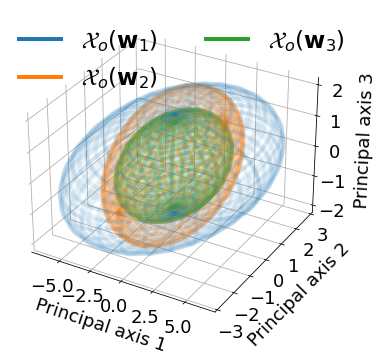

In [132]:
# plot gramian ellipsoids
savefig = False

X1,Y1,Z1 = get_ellipsoid(Xo1_proj)
X2,Y2,Z2 = get_ellipsoid(Xo2_proj)
X3,Y3,Z3 = get_ellipsoid(Xo3_proj)

fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw=dict(projection='3d'))

ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:blue',label=r'$\mathcal{X}_o(\mathbf{w}_1)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:orange',label=r'$\mathcal{X}_o(\mathbf{w}_2)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:green',label=r'$\mathcal{X}_o(\mathbf{w}_3)$')
ax.plot_wireframe(X1,Y1,Z1, color='tab:blue', alpha=0.1)
ax.plot_wireframe(X2,Y2,Z2, color='tab:orange', alpha=0.15)
ax.plot_wireframe(X3,Y3,Z3, color='tab:green', alpha=0.2)
ax.set_xlabel('Principal axis 1',labelpad=10)
ax.set_ylabel('Principal axis 2',labelpad=10)
ax.set_zlabel('Principal axis 3',labelpad=10)
# get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_ylim(-3,3)
ax.set_xlim(-7,7)
# ax.set_zlim(-2,2)
plt.legend(frameon=False,ncol=2,bbox_to_anchor=(1.1,1.00),fontsize=23)
if savefig: 
    plt.savefig(figDir + 'fig3/gramian_ellipsoids.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

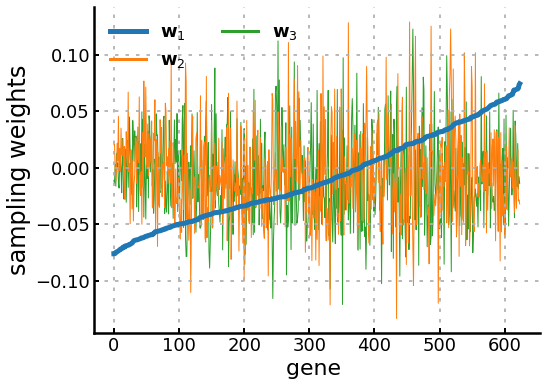

In [145]:
# visualize the weights in gene sampling vector
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(8,6))
# ax.plot(range(len(Wsorted[0])),(np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/
#            (np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),color='k',lw=3)

these_inds = np.argsort(V[:,0]) # sort genes by top eigenvector of the Gram matrix
ax.plot(V[:,0][these_inds],c='tab:blue',lw=5,label=r'$\mathbf{w}_1$',zorder=1)
ax.plot([],[],'-',c='tab:orange',lw=3,label=r'$\mathbf{w}_2$')
ax.plot([],[],'-',c='tab:green',lw=3,label=r'$\mathbf{w}_3$')
ax.plot(V[:,2][these_inds],c='tab:green',lw=1,zorder=0)
ax.plot(V[:,1][these_inds],c='tab:orange',lw=1,zorder=0)
# p2=ax.fill_between(range(len(Csorted)),Csorted-5*Csorted_err,Csorted+5*Csorted_err,color='tab:blue',alpha=0.5)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
ax.set_xlabel('gene ',fontsize=22);
ax.set_ylabel('sampling weights',fontsize=24);
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
plt.legend(frameon=False,ncol=2)
if savefig:
    plt.savefig(figDir + 'fig3/sampling_weights.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# histogram of the weights in C
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(11,4))
ax.hist((np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/(np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),
        bins=20,fc=(1, 1, 1, 0.5),rwidth=0.75,align='right',linewidth=2.5,edgecolor='k')
# ax.hist(promoter_lens,6,alpha=0.75,edgecolor='k',linewidth=2.5,rwidth=0.8)

ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
ax.set_xlabel('sampling weights',fontsize=22);
ax.set_ylabel('frequency',fontsize=22);
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
if savefig:
    plt.savefig(figDir + 'fig3/sampling_weights_hist.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

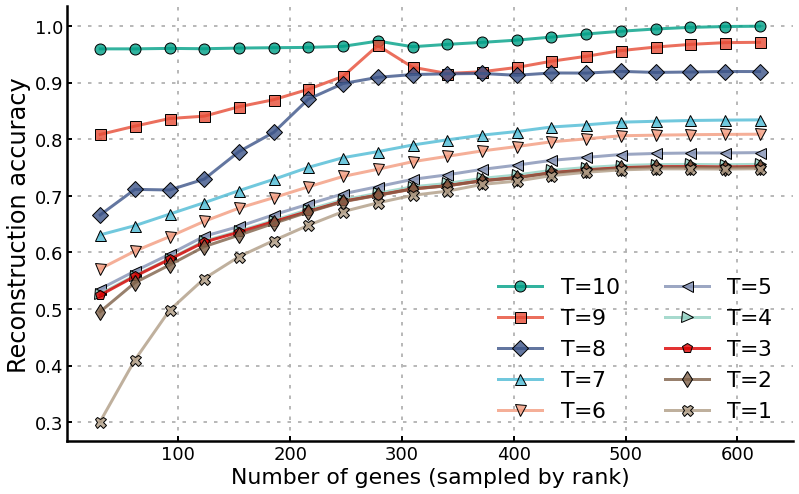

In [74]:
# state estimation error
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
plt.rc('lines',linewidth=4);
plt.rc('lines',markersize=16);

# these_colors = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
fig,ax = plt.subplots(1,1,figsize=(13,8));
oo = 70
mec = 'k'
mew = 1
alpha = 1
xrange = np.linspace(samplingFreq,620,len(rho_list[0]))[:oo] 
my_labels = [r'T=$10$',r'T=$9$',r'T=$8$',r'T=$7$',r'T=$6$',r'T=$5$',r'T=$4$',r'T=$3$',r'T=$2$',r'T=$1$']
my_markers = ['o','s','D','^','v','<','>','p','d','X']
for ii in range(len(rho_list)):
    ax.plot(xrange,rho_list[ii][:oo],my_markers[ii]+'-',mfc=npg_color_list[ii]+[0.8],c=npg_color_list[ii]+[0.8],
            mec=mec,mew=mew,ms=11,lw=3,label=my_labels[ii])
# ax.set_xticks([1,20,40,60,80])
ax.set_xlabel('Number of genes (sampled by rank)',fontsize=22);
ax.set_ylabel('Reconstruction accuracy',fontsize=24);
# ax.set_ylabel(r'$\mathregular{\rho(\mathbf{z}_0,\mathcal{O}_T^{\dagger} \mathbf{y})}$',fontsize=26);
ax.legend(frameon=False,ncol=2,fontsize=22)
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2.5)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
if savefig: 
    plt.savefig(figDir + 'fig3/state_estimation_error.pdf',dpi=300,bbox_inches='tight',transparent=True)    
plt.show();

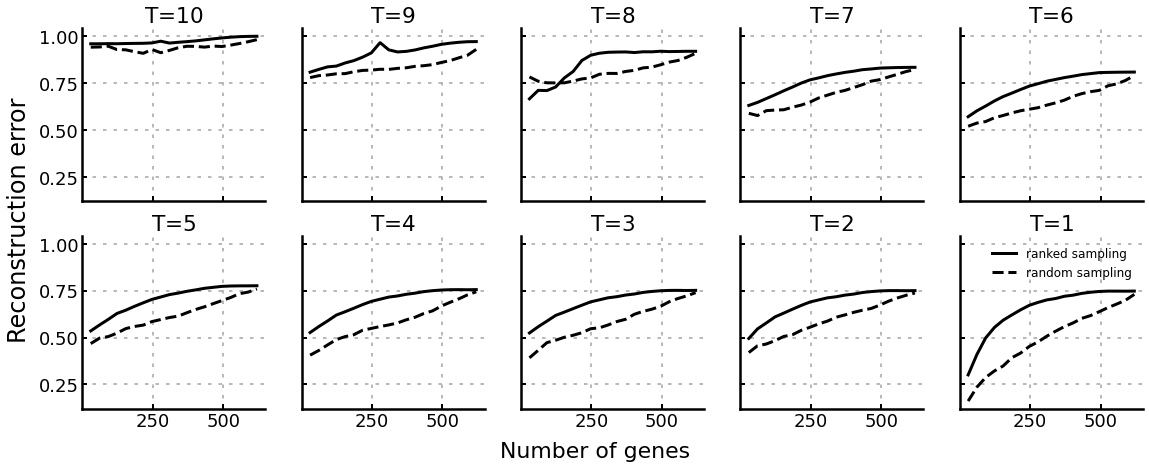

In [28]:
# state estimation error compared with random sampling
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
plt.rc('lines',linewidth=3);

fig,axs = plt.subplots(2,5,figsize=(19,7),sharex=True,sharey=True);
mec = 'k'
mew = 1
alpha = 0.8
xrange = np.linspace(samplingFreq,620,len(rho_list[0]))
my_labels = [r'T=$10$',r'T=$9$',r'T=$8$',r'T=$7$',r'T=$6$',r'T=$5$',r'T=$4$',r'T=$3$',r'T=$2$',r'T=$1$']
my_markers = ['o','s','D','^','v','<','>','p','d','X']
for ii,ax in enumerate(axs.reshape(-1)):
    ax.set_title(my_labels[ii])
    ax.plot(xrange,rho_list[ii],'k')
    ax.plot(xrange,rho_rand_list[ii],'--',c='k')
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
ax.legend(['ranked sampling','random sampling'],frameon=False,fontsize=12)
fig.text(0.5, 0.03, 'Number of genes', ha='center',fontsize=22);
fig.text(0.07, 0.5, 'Reconstruction error', va='center', rotation='vertical',fontsize=24);
if savefig: 
    plt.savefig(figDir + 'supplementalFigs/rand_estimation_error.pdf',dpi=300,bbox_inches='tight',transparent=True)    
plt.show();

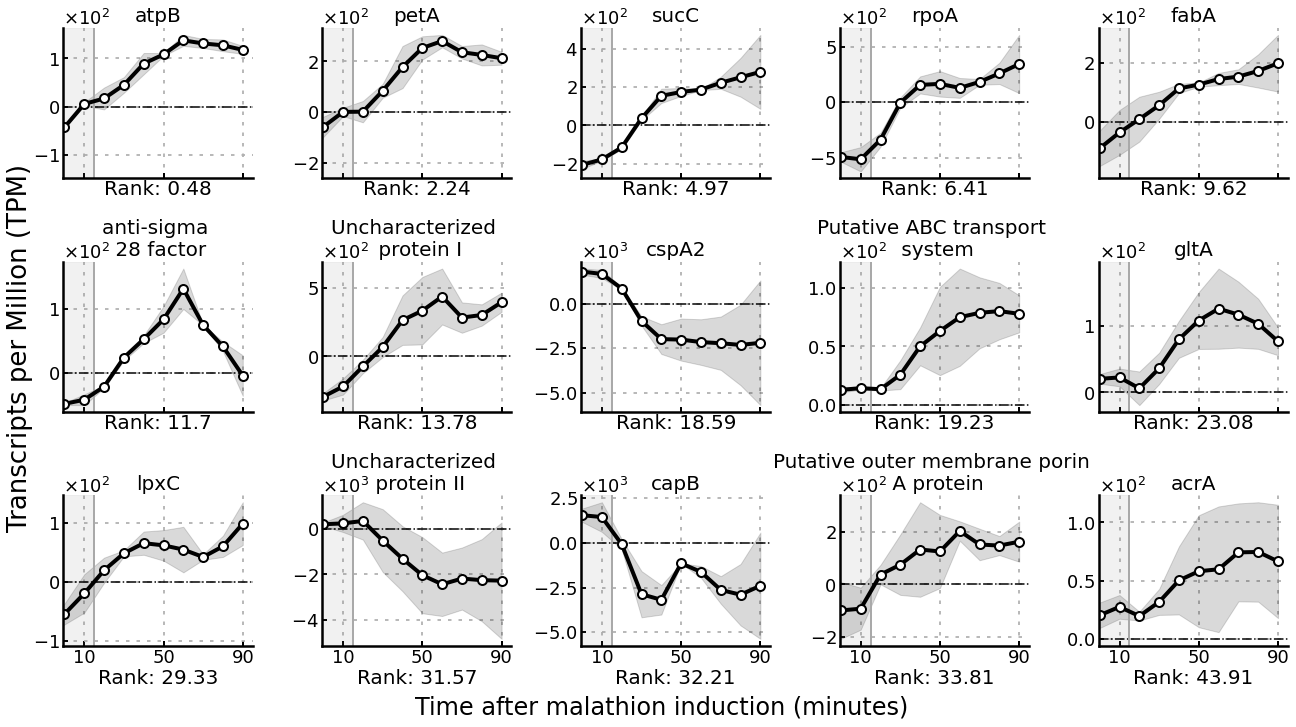

In [151]:
# sensor gene TPMs
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

full_tspan = list(range(-10,100,10))

fig, axs = plt.subplots(3,5,figsize=(18,10),sharex=True); 
# fig.delaxes(axs[-1,-1])
# fig.delaxes(axs[-1,-2])
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(tags):
        ax.set_title(df_up_new.gene[ii],fontsize=20)
#         pC = savgol(data_c_orig[keepers][df_up_new.tag_ind[ii]],5,2,axis=0)
#         pT = savgol(data_t_orig[keepers][df_up_new.tag_ind[ii]],5,2,axis=0)
#         mC = np.mean(pC,axis=1)
#         sC = np.std(pC,axis=1)
#         mT = np.mean(pT,axis=1)
#         sT = np.std(pT,axis=1)        
#         ax.plot(full_tspan,mC,'o--',ms=10,mec='k',mew=1,c='k',alpha=0.7)#c=npg_colors[2])
#         ax.plot(full_tspan,mT,'s-',ms=9,mec='k',mew=1,c='tab:red',alpha=0.7)#c=npg_colors[1])
#         ax.fill_between(full_tspan,mC-sC,mC+sC,color='k',alpha=0.1)
#         ax.fill_between(full_tspan,mT-sT,mT+sT,color='tab:red',alpha=0.1)
        pBS = savgol(data_t_orig[keepers][df_up_new.tag_ind[ii]] - data_c_orig[keepers][df_up_new.tag_ind[ii]],5,2,axis=0)
        mBS = np.mean(pBS,axis=1)
        sBS = np.std(pBS,axis=1)
        ax.plot(full_tspan,mBS,'o-',ms=9,mec='k',mew=2,c='k',mfc='white')
        ax.fill_between(full_tspan,mBS-sBS,mBS+sBS,color='k',alpha=0.15)
        ax.set_xlabel('Rank: ' +str(df_up_new.obs_rank[ii]),fontsize=20,labelpad=2)
        ax.set_xticks(range(10,90+40,40))
        for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
            ax.spines[side].set_linewidth(2.5)    
        ax.axvspan(-1,15,color='tab:gray',alpha=0.1)
        ax.set_xlim(-0.5,)
        xmin,xmax = ax.get_xlim()
        ax.hlines(0.0,xmin,xmax,color='k',linestyle='-.',lw=1.5)
#         ax.xaxis.set_ticks(np.arange(20, 120, 40))
        ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
        ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
        ymin,ymax = ax.get_ylim()
        ax.vlines(15,ymin,ymax,color='darkgray',lw=2)
        ax.set_ylim(ymin,ymax)

# ax.legend(['control','malathion \n (1.3mM)'],frameon=False,fontsize=22);
fig.text(0.5, -0.01, 'Time after malathion induction (minutes)', ha='center',fontsize=24);
fig.text(-0.005, 0.5, 'Transcripts per Million (TPM)', va='center', rotation='vertical',fontsize=26);
# plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.tight_layout();

if savefig: 
    plt.savefig(figDir + 'fig3/library_genes_rnaseq.pdf',bbox_inches='tight',transparent=True,dpi=300);


#### New versions of subfigures for sensor placement results (since closed-form solution was found)

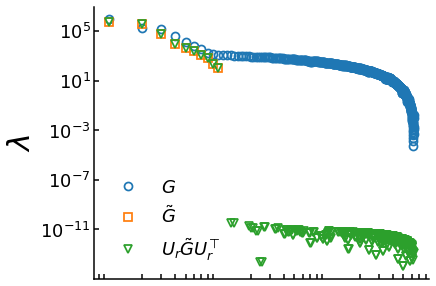

In [75]:
# compare the eigenvalues of the three Gram matrices
savefig=False
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(np.linspace(1,len(D),len(D)),np.real(D),'o',mfc='None',ms=8,mew=1.75,label=r'$G$')
ax.plot(np.linspace(1,len(Dt),len(Dt)),np.real(Dt),'s',mfc='None',ms=8,mew=1.75,label=r'$\tilde{G}$')
ax.plot(np.linspace(1,len(D),len(D)),np.real(Dt_recon),'v',mfc='None',ms=8,mew=1.75,label=r'$U_r\tilde{G}U_r^\top$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([])
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
ax.set_ylabel(r'$\lambda$',fontsize=30)
plt.legend(frameon=False,ncol=1)
if savefig: 
    plt.savefig('/Users/aqib/desktop/gram_eigvals.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


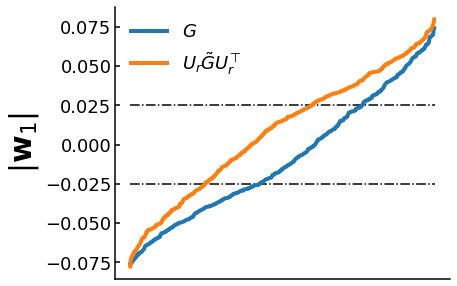

In [76]:
# compare top eigenvector of the three Gram matrices
savefig=False
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(np.sort((V[:,0])),label=r'$G$')
# ax.plot(np.linspace(0,623,10),np.sort(Vt[:,0]),label=r'$\tilde{G}$')
ax.plot(np.sort((np.real(Vt_recon[:,0]))),label=r'$U_r\tilde{G}U_r^\top$')
ax.hlines(0.025,0,len(A),linestyle='-.',lw=1.5,color='k')
ax.hlines(-0.025,0,len(A),linestyle='-.',lw=1.5,color='k')
ax.set_xticks([])
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
ax.set_ylabel(r'$|\mathbf{w}_1|$',fontsize=30)
plt.legend(frameon=False,ncol=1)
if savefig: 
    plt.savefig('/Users/aqib/desktop/gram_1eigvec.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

#### Misc figs

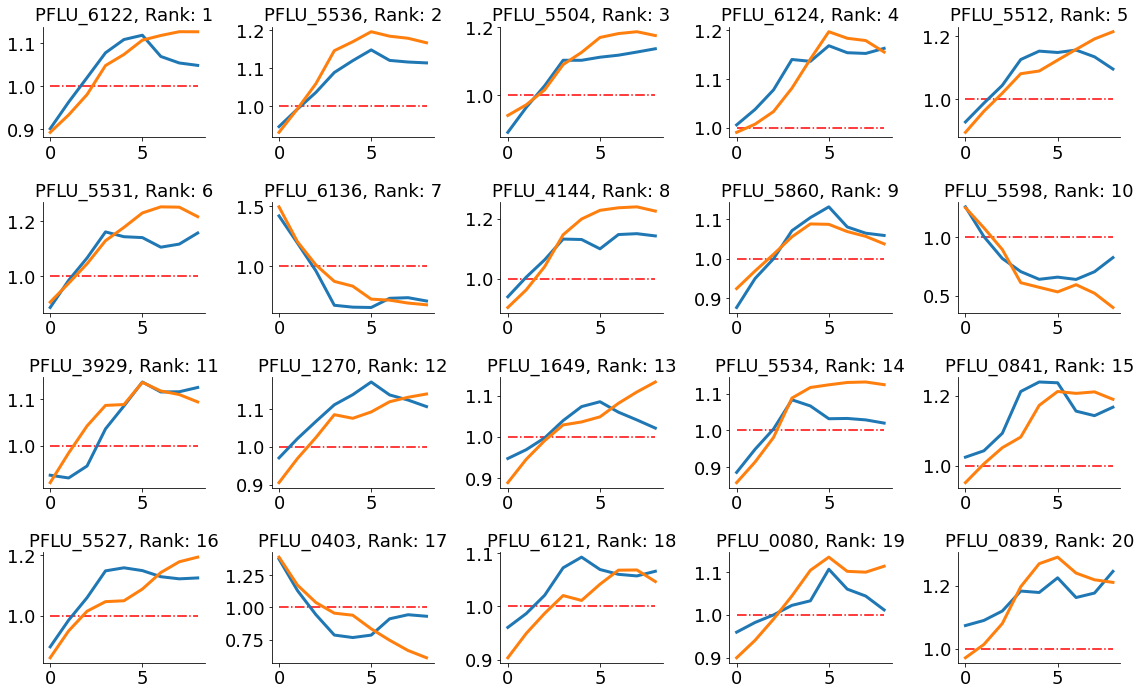

In [15]:
fig,axs = plt.subplots(4,5,figsize=(16,10))
count = 0
for ii in range(len(A)-1,len(A)-21,-1): # plot the top 20 genes
    ax = axs.reshape(-1)[count]
    ax.set_title(sorted_tags[ii]+', Rank: ' + str(len(A) - ii),fontsize=18)
    ax.plot(data_fc[sorted_inds[ii]])
    ax.hlines(1.0,0,8,color='red',linestyle='-.',lw=1.5)
    count += 1
plt.tight_layout()
plt.show()

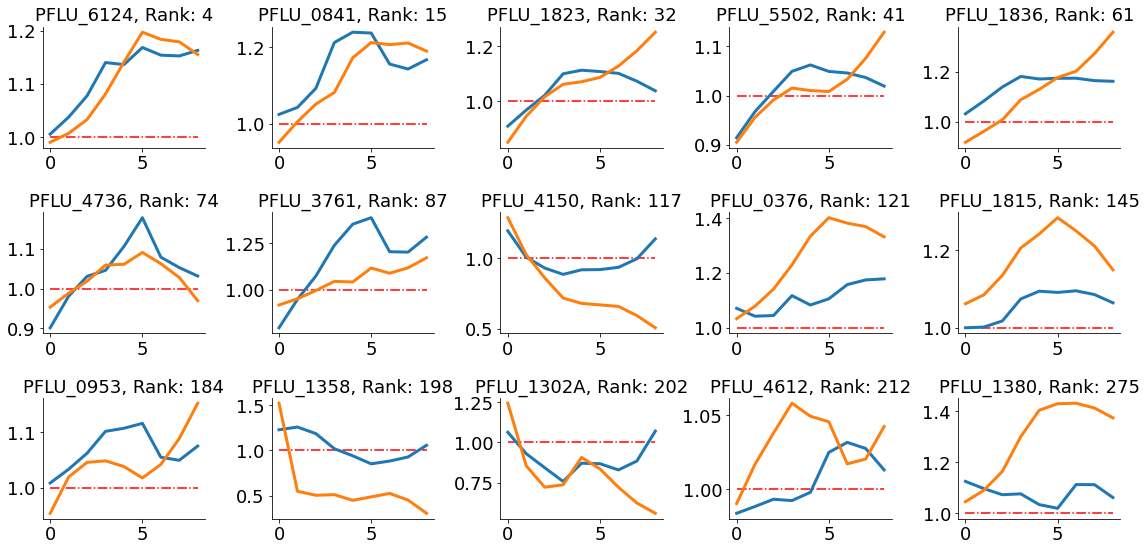

In [16]:
these_tags = ['6124','0841','1823','5502','1836','4736','3761','4150','0376','1815','0953','1358','1302A','4612','1380']
these_tags = ['PFLU_' + x for x in these_tags]
fig,axs = plt.subplots(3,5,figsize=(16,8))
for ii,ax in enumerate(axs.reshape(-1)): # plot the 15 encoder genes from the library
    ax.set_title(these_tags[ii]+', Rank: ' + str(len(A) - sorted_tags.index(these_tags[ii])) ,fontsize=18)
    ax.plot(data_fc[locus_tags_keep.index(these_tags[ii])])
    ax.hlines(1.0,0,8,color='red',linestyle='-.',lw=1.5)
plt.tight_layout()
plt.show()

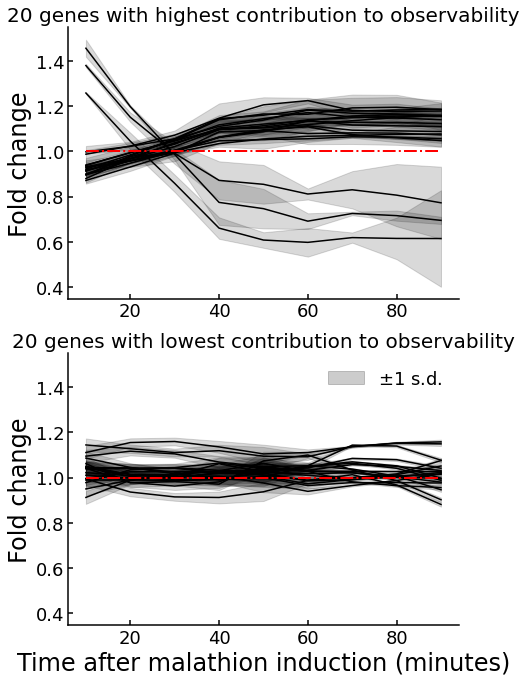

In [152]:
# plot genes which contribute most and least to observability 
savefig = False
cmap = sns.diverging_palette(20, 230, as_cmap=True)
crange = np.linspace(0,1,len(these_tags))
ngenes = 20
fig, ax = plt.subplots(2,1,figsize=(7,11),sharey=True)
for cnt,ii in enumerate(range(len(A)-1,len(A)-ngenes+1,-1)): 
    ax[0].set_title(str(ngenes)+' genes with highest contribution to observability',fontsize=20)
    mu = np.mean(data_fc[sorted_inds[ii]],axis=1)
    std = np.std(data_fc[sorted_inds[ii]],axis=1)
    ax[0].plot(corr_tspan,mu,c='k',lw=1.5,ms=3,zorder=0)
    ax[0].fill_between(corr_tspan,mu-std,mu+std,color='k',alpha=0.15)
ax[0].plot([10,90],[1,1],color='r',linestyle='-.',lw=2,zorder=1)
ax[0].set_ylabel('Fold change',fontsize=24)
# plt.xlabel('Time after malathion induction (minutes)')
# plt.savefig('/Users/aqib/desktop/top_genes.pdf',dpi=300,transparent=True,bbox_inches='tight')

for cnt,ii in enumerate(range(ngenes)): 
    ax[1].set_title(str(ngenes)+' genes with lowest contribution to observability',fontsize=20)
    mu = np.mean(data_fc[sorted_inds[ii]],axis=1)
    ax[1].plot(corr_tspan,mu,c='k',lw=1.5,ms=3,zorder=0)
    ax[1].fill_between(corr_tspan,mu-std,mu+std,color='k',alpha=0.15)
ax[1].fill_between([],[],[],color='k',alpha=0.2,label=r'$\pm 1$ s.d.')
ax[1].plot([10,90],[1,1],color='r',linestyle='-.',lw=2,zorder=1)
ax[1].set_ylabel('Fold change',fontsize=24)
ax[1].set_xlabel('Time after malathion induction (minutes)',fontsize=24)
ax[1].legend(frameon=False)

for this_ax in ax.reshape(-1):
    for side in this_ax.spines.keys():
        this_ax.spines[side].set_linewidth(1.5)
        this_ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
        this_ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
if savefig: 
    plt.savefig(figDir+'fig3/top_and_bottom_genes.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()    

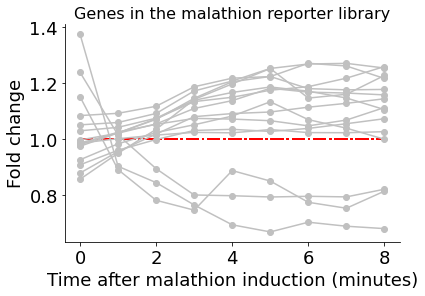

In [18]:
# plot these_tags in a single plot (just their means)
cmap = cm.get_cmap('Spectral')
# cmap = sns.diverging_palette(20, 230, as_cmap=True)
crange = np.linspace(0,1,len(these_tags))
plt.figure()
for ii,tag in enumerate(these_tags): 
    plt.title('Genes in the malathion reporter library',fontsize=16)
    mu = np.mean(data_fc[locus_tags_keep.index(tag)],axis=1)
#     sigma = np.std(data_fc[locus_tags_keep.index(tag)],axis=1)
    plt.hlines(1.0,0,8,color='r',linestyle='-.',lw=2)
#     plt.plot(mu,c=cmap(crange[ii]))01
    plt.plot(mu,'o-',c='silver',lw=1.5)
plt.ylabel('Fold change')
plt.xlabel('Time after malathion induction (minutes)')
# plt.savefig('/Users/aqib/desktop/selected_genes.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [ ]:
# figures that didn't make it into the manuscript
# the few above ones
# gramian ellipsoids (added for now)
# gramian eigenvalues
# gram matrix eigenvalues
# DMD r eigenvalue comparison
# encoder genes for each condition separately 
